# Multiclass classification

In [37]:
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from preprocessing import preprocess_chunks_for_multiclass_test_one_handed, concat_chunks_for_feature_extraction, \
    segment_for_null_classification


sample_rate = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
window_size = 50
# MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters
feature_calculation_setting = MinimalFCParameters()

# Ana-2, Ariane, Julian, Wiki
experiment_dirs_selected = ["Ana-2","Anne","Ariane","Cilly","Fabi","Julian","Julius","Wiktoria"]
#experiment_dirs_selected = ["Julius"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]


Preprocess data

In [39]:
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


In [40]:
if use_indoor:
    chunks_ocd, chunks_null_class, y_ocd = preprocess_chunks_for_multiclass_test_one_handed(chunks, null_chunks, y)
    # TODO: check the sets of action ids again

#TODO: handle no indoor

In [41]:
labels = y_ocd.loc[:, "label"].squeeze()
assert len(labels) == len(chunks_ocd)

labels_ocd_multiclass = labels.reset_index(drop=True)
chunks_ocd_segmented, labels_ocd_segmented_multiclass, chunks_null_segmented, labels_null_segmented = segment_for_null_classification(chunks_ocd, chunks_null_class, window_size, labels)

assert len(set(labels_ocd_multiclass)) == len(set(labels_ocd_segmented_multiclass))

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


In [42]:
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

# with null class
multi_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])

assert len(labels_multi_class_classification) == len(chunks_ocd_segmented) + len(chunks_null_segmented)
assert len(multi_class_df.loc[:, "action_id"].unique()) == len(chunks_ocd_segmented) + len(chunks_null_segmented)

assert len(set(labels_multi_class_classification)) == labels.nunique() + 1
# without null class
"""
multi_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented],
        [labels_ocd_segmented_multiclass])
"""
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass)) + 1

In [43]:
# the one handed activities
assert set(labels_multi_class_classification) == {'checking oven',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door',}

### Feature extraction for multi class OCD activities incl null

In [44]:
X_multi_class_classification = extract_timeseries_features(multi_class_df, use_indoor=use_indoor, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


In [45]:
import pandas as pd
print(pd.Series(multi_class_df.loc[:, "action_id"].unique()))

0           (0, 0)
1           (0, 1)
2           (0, 2)
3           (1, 0)
4           (1, 1)
           ...    
14301    (2550, 1)
14302    (1917, 0)
14303    (1917, 1)
14304    (2551, 0)
14305    (2551, 1)
Length: 14306, dtype: object


### Feature selection for multi class OCD activities incl null

In [47]:
X_multi_class_classification.head()
# TODO: something seems to be weird about the length of the chunks. Some have a length of 200, others 100 and others only 50


impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, labels_multi_class_classification)

In [ ]:
X_multi_class_classification_selected

In [48]:
scaler = StandardScaler()
X_multi_class_classification_scaled = scaler.fit_transform(X_multi_class_classification_selected)

### Train models and score results

Multi class classification: using indoor: True; FC params: MinimalFCParameters; window_size 50
Logistic Regression: 0.91 +/- 0.00


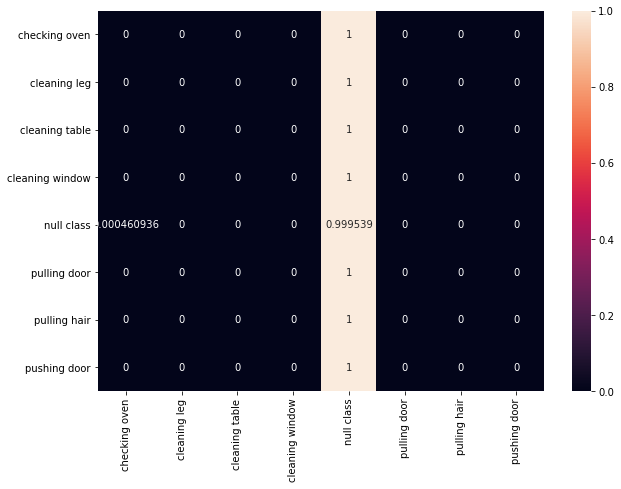

In [50]:
print("Multi class classification: using indoor: {}; FC params: {}; window_size {}".format(use_indoor,feature_calculation_setting.__class__.__name__, window_size))
classify_all(X_multi_class_classification_scaled, labels_multi_class_classification)

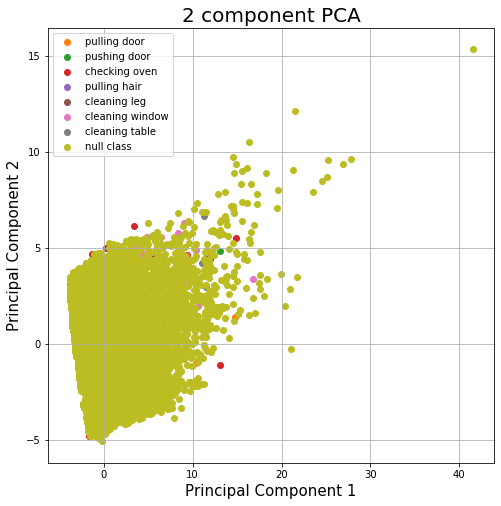

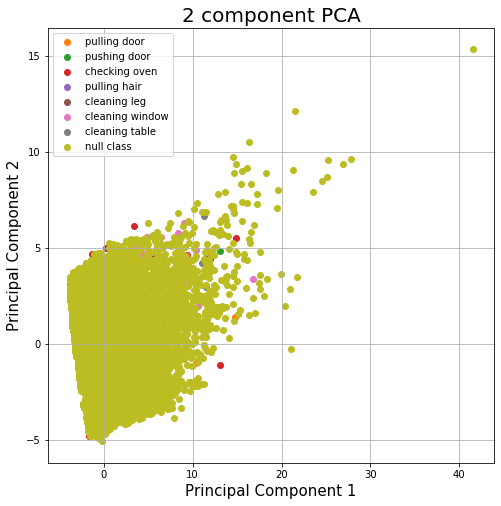

In [51]:
from visualization._visualization import pca_2d, sne_2d
pca_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])


In [ ]:
sne_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])

In [ ]:
labels_multi_class_classification.unique()

In [ ]:
len(labels_null_segmented)/ len(labels_multi_class_classification)